In [1]:
%matplotlib widget

import numpy as np
import matplotlib.pyplot as plt
import h5py
import pandas as pd
from astropy.units import Unit
from astropy.cosmology import Planck18

def inspect_hdf5_group(group, level=0):
    groupname = group.name if group.name else "/"
    print("\t" * level + f"Group: {groupname}")
    # print all datasets
    for key in group.keys():
        if isinstance(group[key], h5py.Dataset):
            ds = group[key]
            print(
                "\t" * (level + 1)
                + f"{key:20s} {str(ds.shape):12s}:  {ds.attrs["description"]:36s}"
                + (f"; Units: {ds.attrs["units"]}" if ds.attrs["units"] else ""),
            )
    # print all groups recursively
    print()
    for key in group.keys():
        if isinstance(group[key], h5py.Group):
            inspect_hdf5_group(group[key], level + 1)

# Reading `hdf5` files

The compute portal allows you to download catalogs in the `hdf5` format, which you can read using the `h5py` library:

In [2]:
halos = h5py.File('./filtered_haloproperties_small.hdf5', 'r')

`h5py.File` objects can be read as dictionaries: their data is distributed in `h5py.Dataset` objects, the list of which can be accessed using the `keys()` method

In [3]:
halos

<HDF5 file "filtered_haloproperties_small.hdf5" (mode r)>

In [4]:
print(halos.keys())

<KeysViewHDF5 ['fof_halo_center_x', 'fof_halo_center_y', 'fof_halo_center_z', 'fof_halo_mass', 'fof_halo_tag', 'sod_halo_M200c', 'sod_halo_R200c', 'sod_halo_cdelta']>


Individual datasets (i.e. physical properties) can then be accessed with said keys -- e.g.,

In [5]:
m200c = halos["sod_halo_M200c"]
print(isinstance(m200c, h5py.Dataset))
tags = halos["fof_halo_tag"]
print(isinstance(tags, h5py.Dataset))

True
True


Each dataset packs metadata containing relevant information, in particular a brief description of the physical property and its unit.
These can be accessed through the `attrs` attribute of a `Dataset` object:

In [6]:
print("m200c description:", m200c.attrs["description"])
print("m200c units:", m200c.attrs["units"])
print("tags description:", tags.attrs["description"])
print("tags units:", tags.attrs["units"])


m200c description: SOD halo mass
m200c units: Msun/h
tags description: FoF halo tag
tags units: 


Packaging all the information you may need on a given file:

In [7]:
inspect_hdf5_group(halos)

Group: /
	fof_halo_center_x    (1000,)     :  FoF halo center x                   ; Units: Mpc/h
	fof_halo_center_y    (1000,)     :  FoF halo center y                   ; Units: Mpc/h
	fof_halo_center_z    (1000,)     :  FoF halo center z                   ; Units: Mpc/h
	fof_halo_mass        (1000,)     :  FoF halo mass                       ; Units: Msun/h
	fof_halo_tag         (1000,)     :  FoF halo tag                        
	sod_halo_M200c       (1000,)     :  SOD halo mass                       ; Units: Msun/h
	sod_halo_R200c       (1000,)     :  SOD halo radius (200c)              ; Units: Mpc/h
	sod_halo_cdelta      (1000,)     :  SOD halo concentration (r200c/rs)   



Each `Dataset` includes one row per object, which can be accessed through its index:

In [8]:
print(f"Mass of first catalog entry: {m200c[0]:.3e} {m200c.attrs['units']}")

Mass of first catalog entry: 1.001e+14 Msun/h


In [9]:
halos.close()

# A look at available data products

## Gravity-only

### Halo properties (without profiles)

In [10]:
halos = h5py.File('./filtered_haloproperties.hdf5', 'r')
inspect_hdf5_group(halos)

Group: /
	fof_halo_center_x    (100000,)   :  FoF halo center x                   ; Units: Mpc/h
	fof_halo_center_y    (100000,)   :  FoF halo center y                   ; Units: Mpc/h
	fof_halo_center_z    (100000,)   :  FoF halo center z                   ; Units: Mpc/h
	fof_halo_mass        (100000,)   :  FoF halo mass                       ; Units: Msun/h
	fof_halo_tag         (100000,)   :  FoF halo tag                        
	sod_halo_M200c       (100000,)   :  SOD halo mass                       ; Units: Msun/h
	sod_halo_R200c       (100000,)   :  SOD halo radius (200c)              ; Units: Mpc/h
	sod_halo_cdelta      (100000,)   :  SOD halo concentration (r200c/rs)   



We can look at halos in the $(x, y, z)$ space:
(note that the volume is not a cube because we limited the number of halos in the query)

In [11]:
plt.close("all")

Text(0, 0.5, 'y [Mpc/h]')

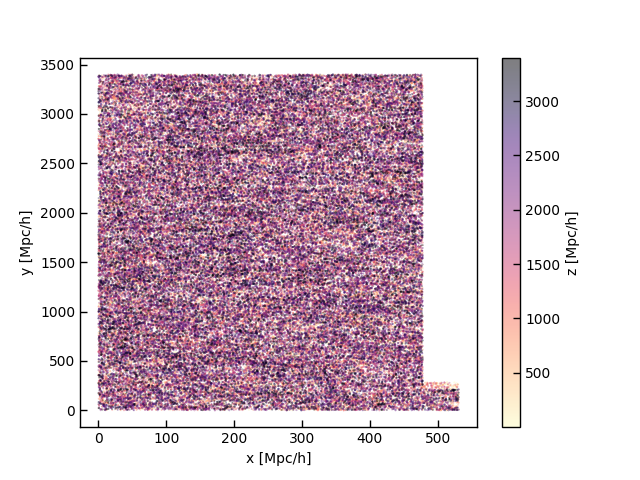

In [12]:
fig, ax = plt.subplots()
sc = ax.scatter(
    np.array(halos["fof_halo_center_x"]),
    np.array(halos["fof_halo_center_y"]),
    c=np.array(halos["fof_halo_center_z"]),  # make halos appear darker with z
    s=np.array(halos["sod_halo_M200c"]) / 1e15,  # make massive halos bigger
    cmap="magma_r",
    alpha=0.5
)
fig.colorbar(sc, ax=ax, label="z [Mpc/h]")
ax.set_xlabel("x [Mpc/h]")
ax.set_ylabel("y [Mpc/h]")

We can also plot e.g. the mass-concentration relation:

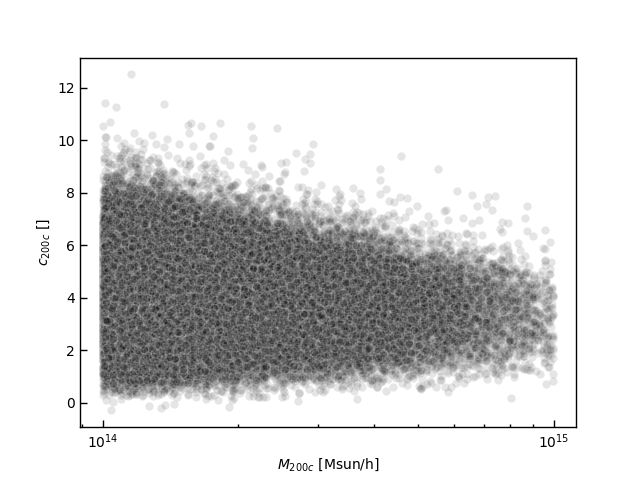

In [13]:
fig, ax = plt.subplots()
m200c, c200c = halos["sod_halo_M200c"], halos["sod_halo_cdelta"]
_ = ax.semilogx(np.array(m200c), np.array(c200c), "ko", mec="w", mew=1, alpha=0.1)
_ = ax.set_xlabel(f"$M_{{200c}}$ [{m200c.attrs['units']}]")
_ = ax.set_ylabel(f"$c_{{200c}}$ [{c200c.attrs['units']}]")

In [14]:
halos.close()

### Halo properties (with profiles)

In [15]:
halos = h5py.File('./filtered_haloproperties_withprofiles.hdf5', 'r')
inspect_hdf5_group(halos)


Group: /
	fof_halo_center_x    (1000,)     :  FoF halo center x                   ; Units: Mpc/h
	fof_halo_center_y    (1000,)     :  FoF halo center y                   ; Units: Mpc/h
	fof_halo_center_z    (1000,)     :  FoF halo center z                   ; Units: Mpc/h
	fof_halo_mass        (1000,)     :  FoF halo mass                       ; Units: Msun/h
	fof_halo_tag         (1000,)     :  FoF halo tag                        
	profile_index        (1000,)     :  Row index of corresponding profile in profile catalog. -1 if no profile.
	sod_halo_M200c       (1000,)     :  SOD halo mass                       ; Units: Msun/h
	sod_halo_R200c       (1000,)     :  SOD halo radius (200c)              ; Units: Mpc/h
	sod_halo_cdelta      (1000,)     :  SOD halo concentration (r200c/rs)   

	Group: /profiles
		bin_index            (1000, 20)  :  Bin index                           
		bin_mass             (1000, 20)  :  Total mass in bin                   ; Units: Msun/h
		bin_radius_left  

#### Plot enclosed mass profiles

Text(0, 0.5, '$M(<r)$ [Msun/h]')

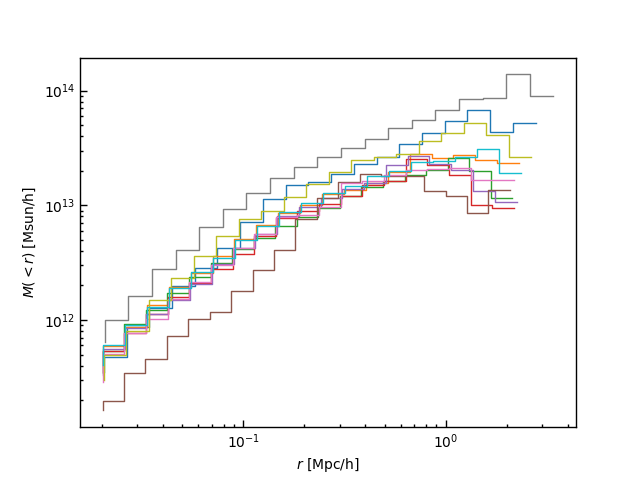

In [16]:
fig, ax = plt.subplots()
for i in range(10):  # range(len(halos["fof_halo_tag"])):
    # r_edges = np.concatenate(([0.0], np.array(halos["profiles"]["bin_radius_right"][i])))
    ax.step(
        np.array(halos["profiles"]["bin_radius_right"][i]),
        np.array(halos["profiles"]["bin_mass"][i]),
        where="pre"
    )
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("$r$ [Mpc/h]")
ax.set_ylabel("$M(<r)$ [Msun/h]")

#### Plot density profiles

Text(0, 0.5, '$\\rho(r)$ [h2 Msun Mpc-3]')

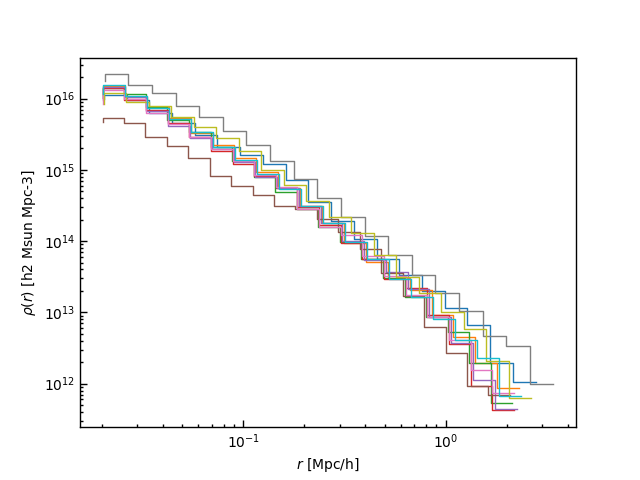

In [17]:
fig, ax = plt.subplots()
for i in range(10):  # range(len(halos["fof_halo_tag"])):
    vol = 4 / 3 * np.pi * (
        halos["profiles"]["bin_radius_right"][i] ** 3
        - halos["profiles"]["bin_radius_left"][i] ** 3
    )
    ax.step(
        np.array(halos["profiles"]["bin_radius_right"][i]),
        np.array(halos["profiles"]["bin_mass"][i]) / vol,
        where="pre"
    )
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("$r$ [Mpc/h]")
ax.set_ylabel("$\\rho(r)$ [h2 Msun Mpc-3]")


In [18]:
halos.close()

### Halo particles

Let's pick a halo in the Last Journey $z=0$ simulation. We'll need its tag to seek particle data

In [19]:
i_halo = 102
halos = h5py.File('./filtered_haloproperties_small.hdf5', 'r')
print(f"Properties of halo {i_halo}:")
for key in halos.keys():
    if isinstance(halos[key], h5py.Dataset):
        print(f"{key:20s}: {halos[key][i_halo]} {halos[key].attrs['units']}")
my_tag = halos["fof_halo_tag"][i_halo]
assert my_tag == 16884490235, "Tag does not match expected value"


Properties of halo 102:
fof_halo_center_x   : 37.75541687011719 Mpc/h
fof_halo_center_y   : 181.4596405029297 Mpc/h
fof_halo_center_z   : 324.2420959472656 Mpc/h
fof_halo_mass       : 118644235304960.0 Msun/h
fof_halo_tag        : 16884490235 
sod_halo_M200c      : 100203986157568.0 Msun/h
sod_halo_R200c      : 0.7553883194923401 Mpc/h
sod_halo_cdelta     : 4.6525092124938965 


In [20]:
i

9

In [21]:
particles = h5py.File(f"./{my_tag}_haloparticles.hdf5", "r")
inspect_hdf5_group(particles)
assert np.all(particles["particles"]["particles"]["fof_halo_tag"] == my_tag), "Tag does not match expected value"

Group: /

	Group: /particles

		Group: /particles/particles
			fof_halo_tag         (43661,)    :  FoF halo tag                        
			id                   (43661,)    :  Particle ID                         
			vx                   (43661,)    :  Particle vx                         ; Units: km/s comoving
			vy                   (43661,)    :  Particle vy                         ; Units: km/s comoving
			vz                   (43661,)    :  Particle vz                         ; Units: km/s comoving
			x                    (43661,)    :  Particle x                          ; Units: Mpc/h comoving
			y                    (43661,)    :  Particle y                          ; Units: Mpc/h comoving
			z                    (43661,)    :  Particle z                          ; Units: Mpc/h comoving

	Group: /surface_densities
		particles            (512, 512)  :  Surface density of particles        ; Units: (Msun/h) / (Mpc/h)^2
		xedges               (513,)      :  x-coordinate of the edges o

Particle data include the particle information (3-demensional positions and velocities), as well as a surface density map along the $z$ axis.

Text(0, 0.5, '$y$ [Mpc/h]')

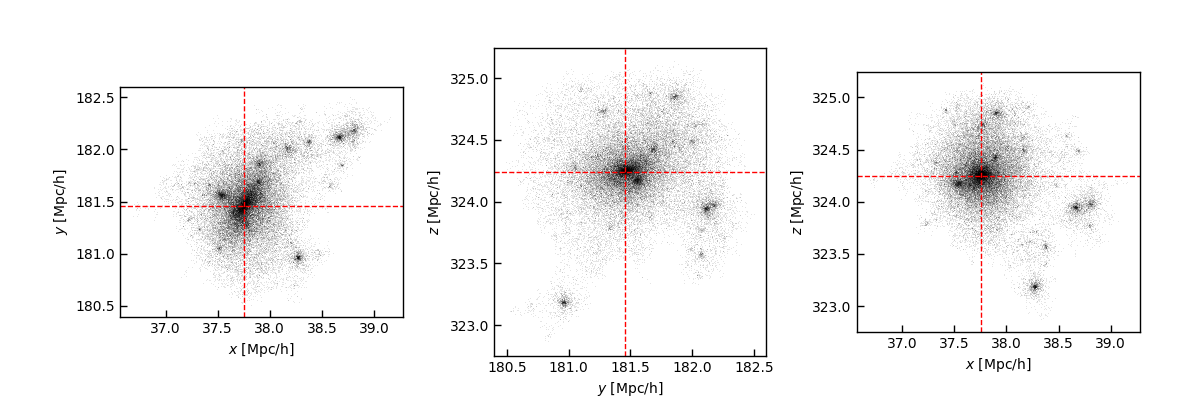

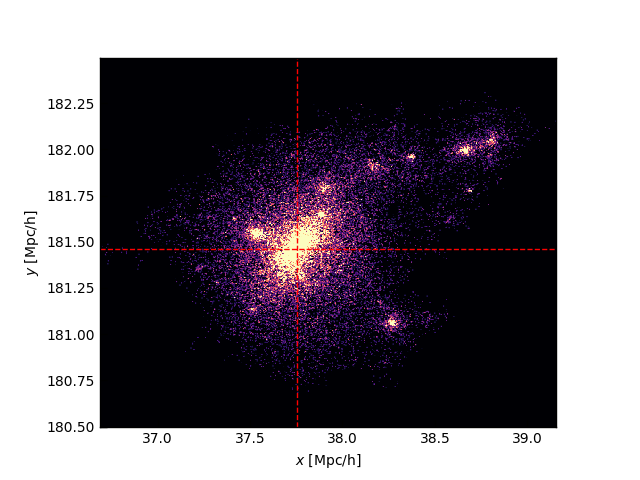

In [22]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
for _x, _y, ax in zip("xyx", "yzz", axs):
    ax.set_aspect("equal")
    ax.plot(
        np.array(particles["particles"]["particles"][_x]),
        np.array(particles["particles"]["particles"][_y]),
        "k,", alpha=0.1
    )
    ax.axvline(halos[f"fof_halo_center_{_x}"][i_halo], 0, 1, color="r", ls="--")
    ax.axhline(halos[f"fof_halo_center_{_y}"][i_halo], 0, 1, color="r", ls="--")
    ax.set_xlabel(f"${_x}$ [Mpc/h]")
    ax.set_ylabel(f"${_y}$ [Mpc/h]")
fig.subplots_adjust(left=0.1, right=0.95, wspace=0.3)

fig, ax = plt.subplots()
ax.set_aspect("equal")
ax.pcolormesh(
    particles["surface_densities"]["xedges"],
    particles["surface_densities"]["yedges"],
    np.array(particles["surface_densities"]["particles"]).T,
    cmap="magma",
    vmin=np.percentile(particles["surface_densities"]["particles"], 1),
    vmax=np.percentile(particles["surface_densities"]["particles"], 99),
)
ax.axvline(halos["fof_halo_center_x"][i_halo], 0, 1, color="r", ls="--")
ax.axhline(halos["fof_halo_center_y"][i_halo], 0, 1, color="r", ls="--")
ax.set_xlabel("$x$ [Mpc/h]")
ax.set_ylabel("$y$ [Mpc/h]")

In [23]:
halos.close()
particles.close()

## Hydrodynamic

### Halo catalogs, with profiles and galaxies

Hydrodynamic runs include quite a lot more information than gravity-only ones:

* SOD halo properties are measured at more overdensities, and include properties for the different physical components (total baryonic matter, gas, stars)
* The same is true for profiles
* Halo queries can also return galaxy information

In [24]:
halos = h5py.File('./filtered_haloproperties_hydro.hdf5', 'r')
inspect_hdf5_group(halos)

Group: /
	fof_halo_center_x    (590,)      :  FoF halo center x                   ; Units: Mpc/h comoving
	fof_halo_center_y    (590,)      :  FoF halo center y                   ; Units: Mpc/h comoving
	fof_halo_center_z    (590,)      :  FoF halo center z                   ; Units: Mpc/h comoving
	fof_halo_mass        (590,)      :  FoF halo mass                       ; Units: Msun/h
	fof_halo_tag         (590,)      :  FoF halo tag                        
	galaxy_index_end     (590,)      :  End index of corresponding galaxies in galaxy catalog (exclusive).
	galaxy_index_start   (590,)      :  Start index of corresponding galaxies in galaxy catalog.
	profile_index        (590,)      :  Row index of corresponding profile in profile catalog. -1 if no profile.
	sod_halo_M200c       (590,)      :  SOD halo mass                       ; Units: Msun/h
	sod_halo_M2500c      (590,)      :  SOD halo mass (2500c)               ; Units: Msun/h
	sod_halo_M500c       (590,)      :  SOD halo mass 

#### (M_bar, M_gas, M_star) vs M_halo

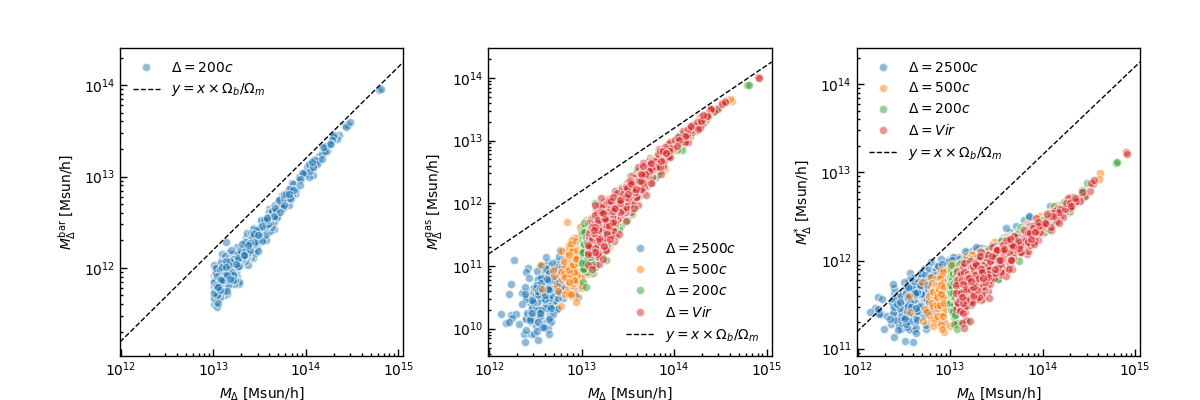

In [25]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4), sharex=True)
fig.subplots_adjust(left=0.1, right=0.95, wspace=0.3)
ObOm = Planck18.Ob0 / Planck18.Om0

ax = axs[0]
ax.loglog(
    np.array(halos["sod_halo_M200c"]),
    np.array(halos["sod_halo_Mbar200c"]),
    "o", label="$\\Delta = 200c$",
    mec="w", mew=1, alpha=0.5
)
ax.set_ylabel(f"$M^{{\\rm bar}}_{{\\Delta}}$ [Msun/h]")

ax = axs[1]
for Delta in ["2500c", "500c", "200c", "Vir"]:
    ax.loglog(
        np.array(halos[f"sod_halo_M{Delta}"]),
        np.array(halos[f"sod_halo_MGas{Delta}"]),
        "o", label=f"$\\Delta = {Delta}$",
        mec="w", mew=1, alpha=0.5
    )
ax.set_ylabel(f"$M^{{\\rm gas}}_{{\\Delta}}$ [Msun/h]")

ax = axs[2]
for Delta in ["2500c", "500c", "200c", "Vir"]:
    ax.loglog(
        np.array(halos[f"sod_halo_M{Delta}"]),
        np.array(halos[f"sod_halo_MStar{Delta}"]),
        "o", label=f"$\\Delta = {Delta}$",
        mec="w", mew=1, alpha=0.5
    )
ax.set_ylabel(f"$M^{{*}}_{{\\Delta}}$ [Msun/h]")

for ax in axs:
    xlim = np.array(ax.get_xlim())
    ax.set_xlim(xlim)
    ax.plot(xlim, ObOm * xlim, "k--", label="$y = x \\times \\Omega_b / \\Omega_m$")
    ax.legend()
    ax.set_xlabel(f"$M_{{\\Delta}}$ [Msun/h]")

#### (Baryon, gas, stellar) fraction profiles

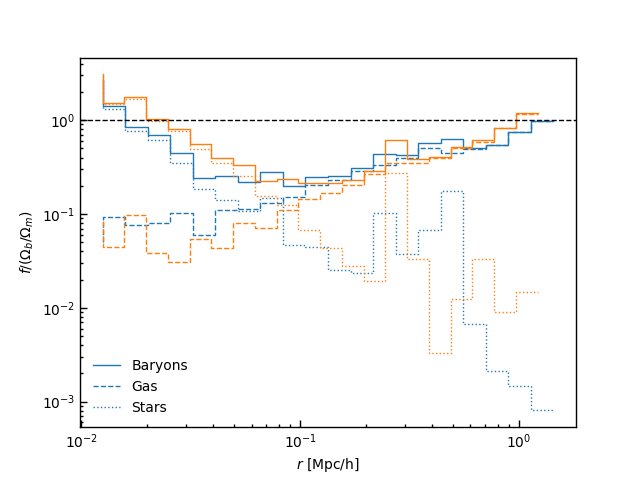

In [26]:
fig, ax = plt.subplots()
ObOm = Planck18.Ob0 / Planck18.Om0

for i in range(2):  # range(len(halos["fof_halo_tag"])):
    vol = 4 / 3 * np.pi * (
        halos["profiles"]["bin_radius_right"][i] ** 3
        - halos["profiles"]["bin_radius_left"][i] ** 3
    )
    gas_frac  = np.array(halos["profiles"]["bin_gas_fraction"][i])
    star_frac = np.array(halos["profiles"]["bin_star_fraction"][i])
    bar_frac = gas_frac + star_frac

    line = ax.step(
        np.array(halos["profiles"]["bin_radius_right"][i]),
        bar_frac / ObOm,
        where="pre", ls="-", label="Baryons" if i == 0 else None
    )
    _ = ax.step(
        np.array(halos["profiles"]["bin_radius_right"][i]),
        gas_frac / ObOm,
        where="pre", ls="--", color=line[0].get_color(),
        label="Gas" if i == 0 else None
    )
    _ = ax.step(
        np.array(halos["profiles"]["bin_radius_right"][i]),
        star_frac / ObOm,
        where="pre", ls=":", color=line[0].get_color(),
        label="Stars" if i == 0 else None
    )

ax.axhline(1.0, 0, 1, color="k", ls="--")
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xlabel("$r$ [Mpc/h]")
ax.set_ylabel("$f / (\\Omega_b / \\Omega_m)$")
ax.legend()

#### Intracluster medium thermodynamics

Text(0, 0.5, '$\\ln K(r)$')

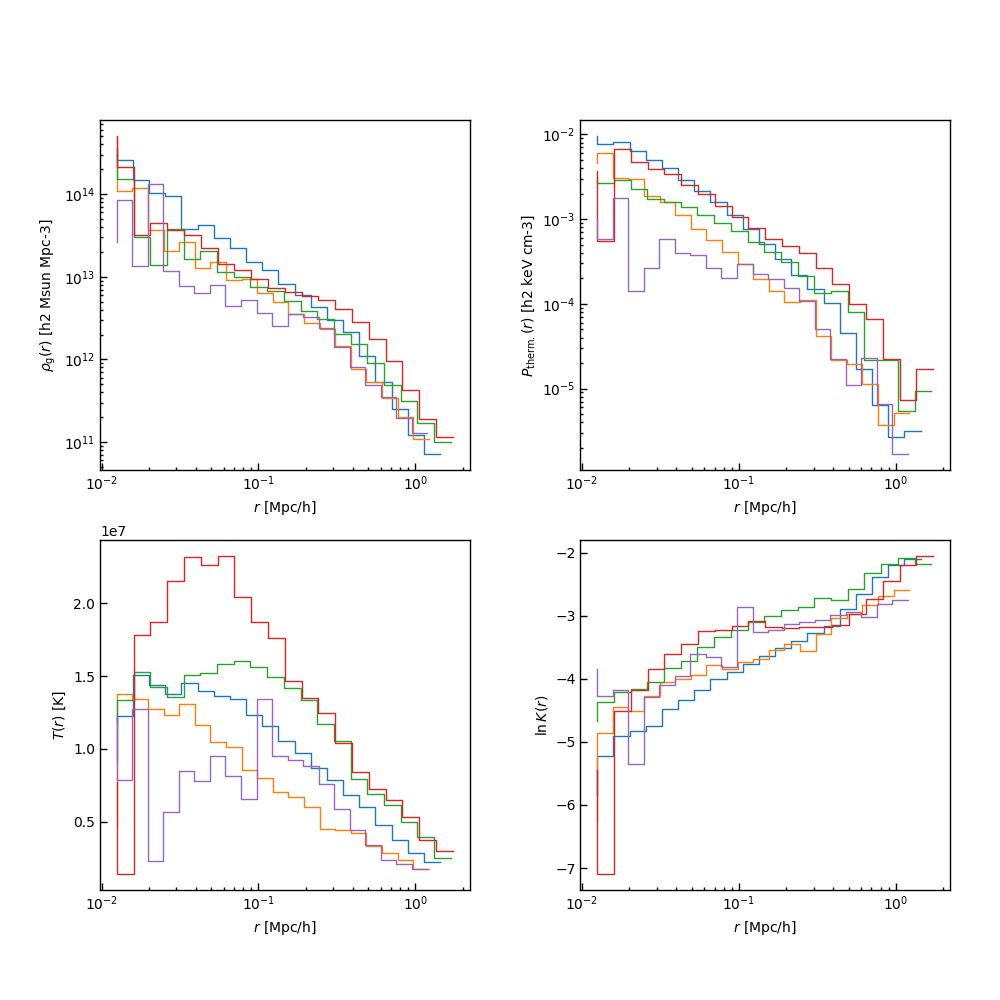

In [27]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs = axs.flatten()
fig.subplots_adjust(left=0.1, right=0.95, wspace=0.3)

for i in range(5):  # range(len(halos["fof_halo_tag"])):
    vol = 4 / 3 * np.pi * (
        halos["profiles"]["bin_radius_right"][i] ** 3
        - halos["profiles"]["bin_radius_left"][i] ** 3
    )

    ax = axs[0]
    ax.step(
        np.array(halos["profiles"]["bin_radius_right"][i]),
        np.array(halos["profiles"]["bin_gas_fraction"][i]) * np.array(halos["profiles"]["bin_mass"][i]) / vol,
        where="pre"
    )

    ax = axs[1]
    ax.step(
        np.array(halos["profiles"]["bin_radius_right"][i]),
        np.array(halos["profiles"]["bin_gas_pthermal"][i]),
        where="pre"
    )

    ax = axs[2]
    ax.step(
        np.array(halos["profiles"]["bin_radius_right"][i]),
        np.array(halos["profiles"]["bin_gas_temperature"][i]),
        where="pre"
    )

    ax = axs[3]
    ax.step(
        np.array(halos["profiles"]["bin_radius_right"][i]),
        np.array(halos["profiles"]["bin_gas_entropy"][i]),
        where="pre"
    )

for ax in axs:
    ax.set_xscale("log")
    ax.set_xlabel("$r$ [Mpc/h]")
axs[0].set_yscale("log")
axs[1].set_yscale("log")

axs[0].set_ylabel("$\\rho_{\\rm g}(r)$ [h2 Msun Mpc-3]")
axs[1].set_ylabel("$P_{\\rm therm.}(r)$ [h2 keV cm-3]")
axs[2].set_ylabel("$T(r)$ [K]")
axs[3].set_ylabel("$\\ln K(r)$")

In [28]:
halos.close()